<a href="https://colab.research.google.com/github/sameer-karim/w207-final-project/blob/project/DT_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data manipulation and numerical operations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and statistical models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_percentage_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
import pandas as pd
import pandas as pd
import numpy as np
from tabulate import tabulate
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Path to your file
file_path = '/content/drive/My Drive/UCB_MIDS_2023/w207/car_price_prediction.csv'

# Load the data into a DataFrame
df = pd.read_csv(file_path)

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
#Data Preprocessing and Splits
#remove km and convert from string to int
df['Mileage'] = df['Mileage'].str.replace(' km', '').astype(int)

# Function to remove 'turbo' and convert to numeric
def clean_engine(value):
    if 'turbo' in value:
        value = value.replace(' turbo', '')
    return pd.to_numeric(value, errors='coerce')

# Apply the function to the 'Engine' column
df['Engine volume'] = df['Engine volume'].apply(clean_engine)

#convert doors from string to numeric
# Function to extract numbers from strings
def extract_numbers(column):
    return column.apply(lambda x: re.findall(r'\d+', x)[0])
#apply doors extraction function to column and re-type as a float
df['Doors'] = extract_numbers(df['Doors']).astype(float)

#NOTE THAT THERE ARE ALWAYS TAXES AND FEES SO WE NEED TO DISCUSS WHAT TO DO WITH THIS COLUMN WHEN 0 OR JUST LEAVE IT AND CALL IT OUT IN PRESENTATION
# Replace non-numeric values (e.g., '-') for the Levy Column - the Levy column is taxes and fees upon purchase
df.replace('-', 0, inplace=True)


# Convert appropriate columns to numeric types (assuming these columns are supposed to be numeric)
#['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']
columns_to_convert=['ID', 'Levy','Price', 'Prod. year', 'Cylinders', 'Airbags','Engine volume', 'Mileage','Doors']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column])

# Drop rows with missing values - there are none but we can leave this here anyway
df.dropna(inplace=True)

# Calculate car age
df['car_age'] = 2024 - df['Prod. year']
#drop prod year - optional
#df = df.drop(columns=['Prod. year'])

# Mileage per year
df['mileage_per_year'] = df['Mileage'] / df['car_age']

#drive train rename
df['Drive wheels'] = df['Drive wheels'].replace('4x4', '4WD')

# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize the label encoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

#Split labels
column_names_list = list(df.columns)
column_names_list.remove('Price')
X_train=df[column_names_list]
Y_train=df['Price']

# Split the data into training and validation sets 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [4]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,car_age,mileage_per_year
0,45654403,13328,1399,31,1005,2010,4,1,2,3.5,186005,6.0,0,0,4.0,0,12,12,14,13286.071429
1,44731507,16621,1018,8,523,2011,4,0,5,3.0,192000,6.0,2,0,4.0,0,1,8,13,14769.230769
2,45774419,8467,0,20,545,2006,3,0,5,1.3,200000,4.0,3,1,4.0,1,1,2,18,11111.111111
3,45769185,3607,862,16,526,2011,4,1,2,2.5,168966,4.0,0,0,4.0,0,14,0,13,12997.384615
4,45809263,11726,446,20,545,2014,3,1,5,1.3,91901,4.0,0,1,4.0,0,12,4,10,9190.100000


In [5]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10383, 19)
X_val shape: (3461, 19)
X_test shape: (3462, 19)
y_train shape: (10383,)
y_val shape: (3461,)
y_test shape: (3462,)


In [6]:
X_train.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,car_age,mileage_per_year
16146,45803483,891,22,1084,2016,9,1,4,2.0,239291,4.0,0,1,4.0,0,12,4,8,29911.375000
10820,45808368,0,5,63,2006,9,0,5,2.0,237000,4.0,1,2,4.0,0,2,6,18,13166.666667
16325,45773277,0,35,236,2008,3,0,5,1.7,120000,4.0,2,1,4.0,0,1,12,16,7500.000000
2787,45615516,530,40,732,2013,4,1,5,1.6,312118,4.0,0,1,4.0,0,1,0,11,28374.363636
8833,45816082,585,22,499,2013,9,1,5,1.8,142786,4.0,0,1,4.0,0,14,12,11,12980.545455


## Decision Tree Implementation

In [7]:
# Initialize the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# Initialize the model - this is just a baseline metric to base hyperparameter tuning
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 127480.64%


In [8]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1266.04%


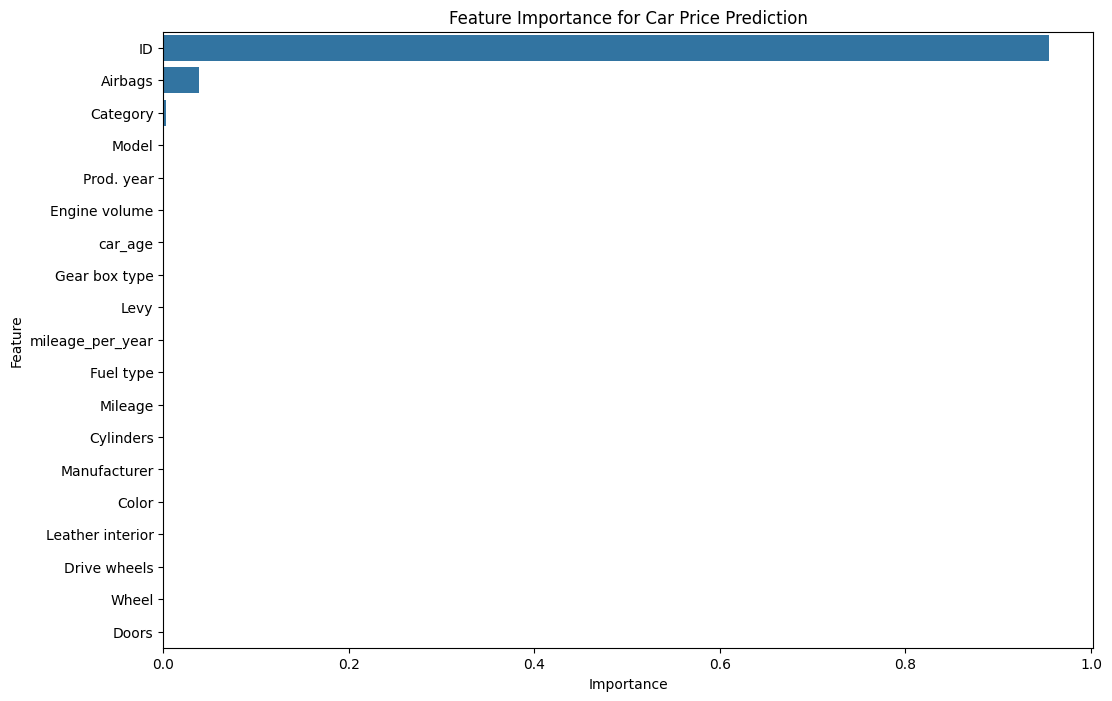

In [9]:
# Feature importance
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()


In [10]:
# With the ID having an overwhelming proportion of the importance, lets drop the column
df = df.drop(columns=['ID'])

In [11]:
# Split labels again after dropping 'ID'
column_names_list = list(df.columns)
column_names_list.remove('Price')
X = df[column_names_list]
Y = df['Price']

# Split the data into training and validation sets 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [12]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE) on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')


Validation MAPE: 849.06%


In [13]:
# Predict on the test set
y_test_pred = dt_regressor.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 1277.73%


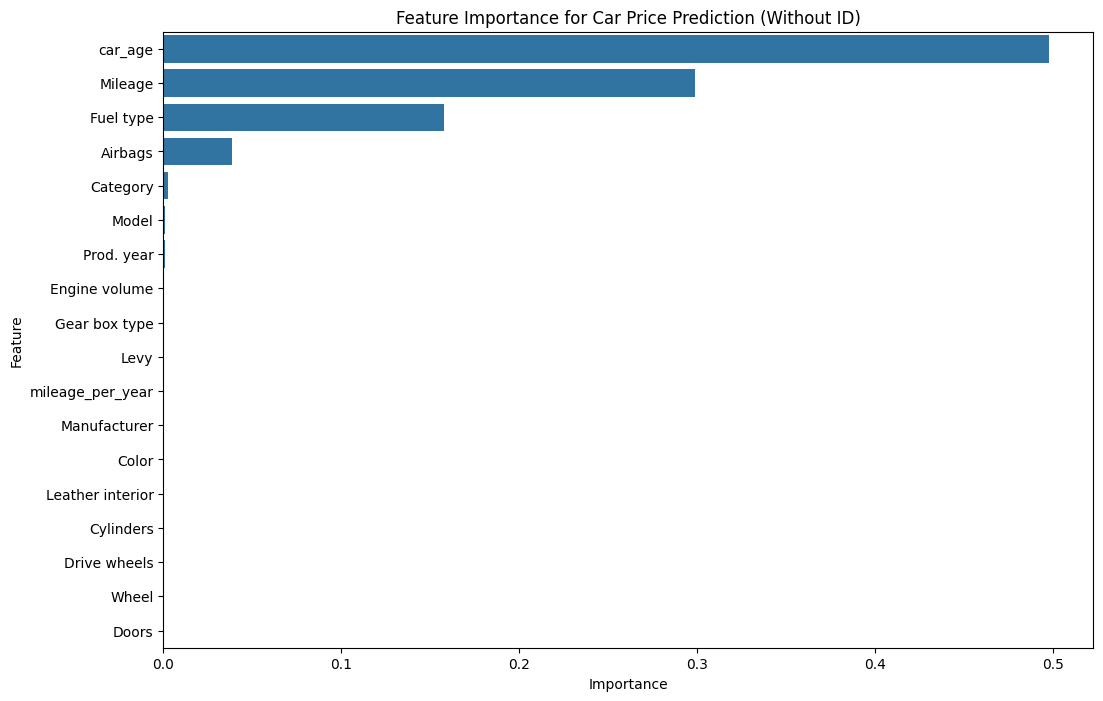

In [14]:
# Feature importance after removing 'ID'
feature_importances = dt_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction (Without ID)')
plt.show()

#### Much better MAPE metric after the ID column was dropped. The feature importance plot shows that car age, mileage, fuel type, and airbags are the top features influencing the the metric. However the metric is still quite high. Since MAPE is still so high, we will pivot to using a Random Forest Regressor. It is an ensemble method that can hopefully capture the complexity of the dataset after some hyperparameter tuning.

#### More Data Preprocessing

In [15]:
# List of categorical columns
categorical_columns = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize the label encoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


#### Training and Baseline Modeling

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = rf_regressor.predict(X_val_scaled)

# Calculate MAPE on the validation set
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE: {val_mape:.2%}')

Validation MAPE: 1004.70%


In [17]:
# Predict on the test set
y_test_pred = rf_regressor.predict(X_test_scaled)

# Calculate Mean Absolute Percentage Error (MAPE) on the test set
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE: {test_mape:.2%}')

Test MAPE: 8778.71%


### Feature Importance

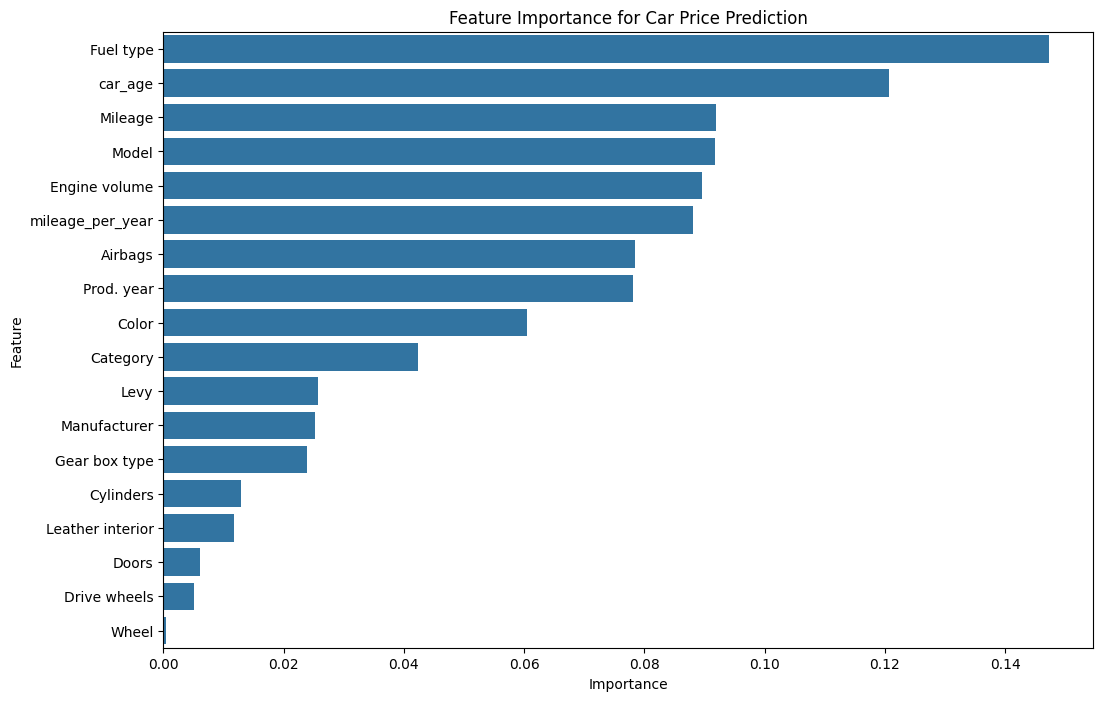

In [18]:
# Feature importance
feature_importances = rf_regressor.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Car Price Prediction')
plt.show()

##### Quite a bit more balanced than the initial DT model created earlier. However, with MAPE values being so high we need to tune hyperparameters.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_distributions,
    n_iter=20,  # Reduced number of parameter settings to sample
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42
)


# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)

# Best score achieved
print("Best Score (Negative MAPE):", random_search.best_score_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 50, 'bootstrap': False}
Best Score (Negative MAPE): -9.408970842738832


In [20]:
# Get the best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val_scaled)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE with Tuning: {val_mape:.2%}')

y_test_pred = best_rf_model.predict(X_test_scaled)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE with Tuning: {test_mape:.2%}')

Validation MAPE with Tuning: 879.90%
Test MAPE with Tuning: 1064.98%


##### MAPE values still quite high, although the test MAPE has been fine-tuned quite a bit. We may have to revisit feature engineering to establish a better baseline.

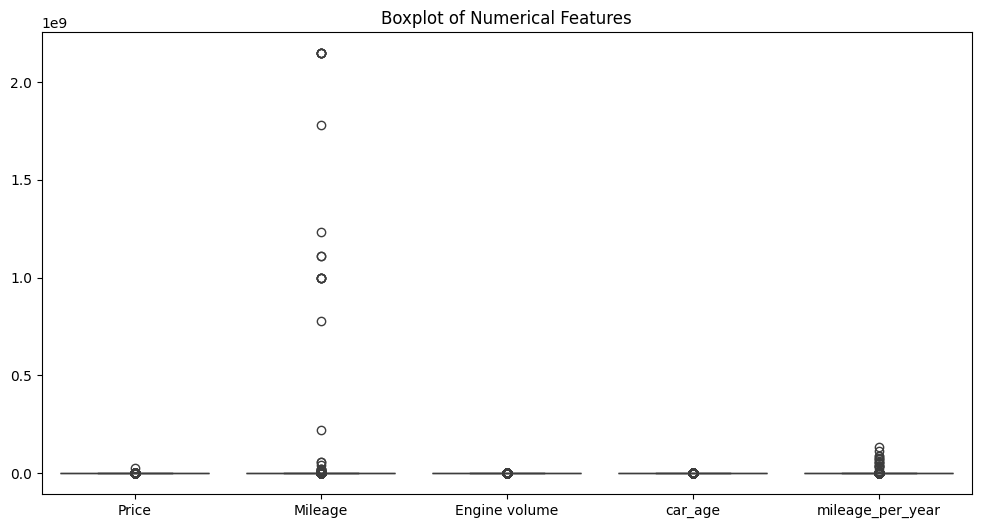

In [21]:
# Boxplot for numerical features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Price', 'Mileage', 'Engine volume', 'car_age', 'mileage_per_year']])
plt.title('Boxplot of Numerical Features')
plt.show()


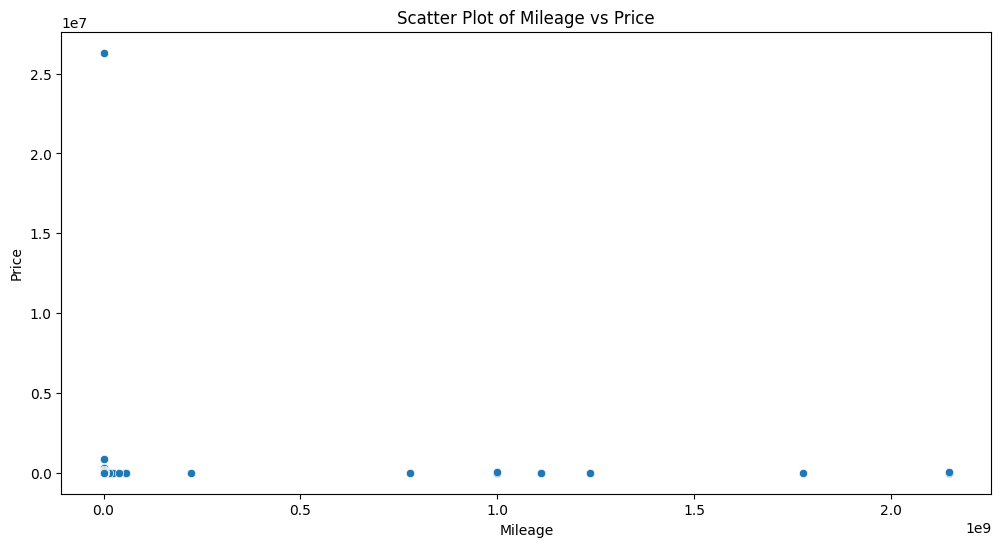

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Mileage', y='Price', data=df)
plt.title('Scatter Plot of Mileage vs Price')
plt.show()

In [23]:
from scipy.stats import zscore

df['Price_zscore'] = zscore(df['Price'])
df['Mileage_zscore'] = zscore(df['Mileage'])

# Identify outliers
price_outliers = df[np.abs(df['Price_zscore']) > 3]
mileage_outliers = df[np.abs(df['Mileage_zscore']) > 3]
print(f'Number of outliers in Price: {price_outliers.shape[0]}')
print(f'Number of outliers in Mileage: {mileage_outliers.shape[0]}')


Number of outliers in Price: 2
Number of outliers in Mileage: 17


In [24]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in Price using IQR: {outliers.shape[0]}')


Number of outliers in Price using IQR: 914


In [25]:
# Check unique values for a categorical column
print(df['Manufacturer'].unique())

[31  8 20 16 22 57 35 41 44  5  3 40 54 11 27 38 53 45 34 18 15 60 23  1
 55 26  0 32 59 17 10 13 37  9 25 30 24 52 12  6 56  7 42 21 50 61  4 63
 58 36 62 47 51 29 33 14 28 39 46 43 49 48  2 19]


In [27]:
print(df.dtypes)

Price                 int64
Levy                  int64
Manufacturer          int64
Model                 int64
Prod. year            int64
Category              int64
Leather interior      int64
Fuel type             int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type         int64
Drive wheels          int64
Doors               float64
Wheel                 int64
Color                 int64
Airbags               int64
car_age               int64
mileage_per_year    float64
Price_zscore        float64
Mileage_zscore      float64
dtype: object


In [29]:
le = LabelEncoder()
df['Manufacturer_encoded'] = le.fit_transform(df['Manufacturer'])
print(df[['Manufacturer', 'Manufacturer_encoded']].drop_duplicates())

       Manufacturer  Manufacturer_encoded
0                31                    31
1                 8                     8
2                20                    20
3                16                    16
5                22                    22
...             ...                   ...
12182            43                    43
12336            49                    49
12534            48                    48
13325             2                     2
18781            19                    19

[64 rows x 2 columns]


In [31]:
df_cleaned = df[(df['Price'] >= (Q1 - 1.5 * IQR)) & (df['Price'] <= (Q3 + 1.5 * IQR))]


In [32]:
# Drop original categorical columns if necessary
df_cleaned = df_cleaned.drop(columns=['Manufacturer'])

# Recalculate features and labels
column_names_list = list(df_cleaned.columns)
column_names_list.remove('Price')
X = df_cleaned[column_names_list]
y = df_cleaned['Price']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)

# Best score achieved
print("Best Score (Negative MAPE):", random_search.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
Best Score (Negative MAPE): -0.0009144426987451121


In [34]:
# Get the best model
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val_scaled)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f'Validation MAPE with Tuning: {val_mape:.2%}')

y_test_pred = best_rf_model.predict(X_test_scaled)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f'Test MAPE with Tuning: {test_mape:.2%}')

Validation MAPE with Tuning: 0.03%
Test MAPE with Tuning: 0.04%
